In [1]:
from Almanac.Data import get_weather_data
from Almanac.Data import get_frost_dates
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = get_weather_data("Chicago, IL", "2015-01-01", "2021-12-31")
df_future = get_weather_data("Chicago, IL", "2022-01-01", "2022-12-31")

In [3]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2015-01-01,-4.3,-8.3,0.0,0.0,0.0,240.0,25.5,NaN,1019.8,NaN
2015-01-02,-1.5,-6.7,2.2,0.0,0.0,NaN,7.8,NaN,1025.3,NaN
2015-01-03,1.6,-0.6,2.8,15.0,0.0,NaN,8.5,NaN,1013.7,NaN
2015-01-04,-3.7,-15.0,2.2,4.6,51.0,305.0,20.2,NaN,NaN,NaN
2015-01-05,-15.6,-18.3,-12.2,3.8,102.0,NaN,17.5,NaN,NaN,NaN


In [4]:
df["tmin"].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2557 entries, 2015-01-01 to 2021-12-31
Freq: D
Series name: tmin
Non-Null Count  Dtype  
--------------  -----  
2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB


<Axes: xlabel='time'>

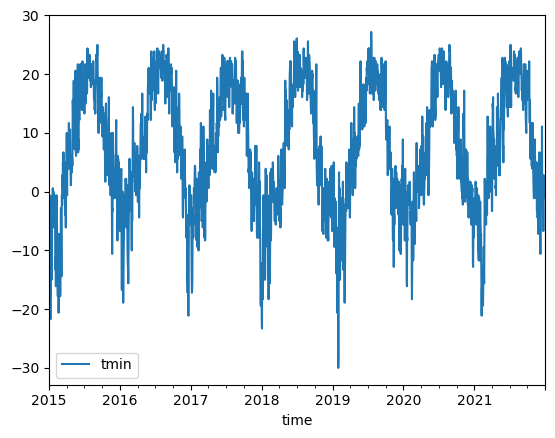

In [5]:
df.plot(y="tmin")

In [6]:
first, last = get_frost_dates(df)

In [7]:
f = pd.Series(first)
s = pd.Series(last)

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
decomp = seasonal_decompose(
    df["tmin"].resample("W").min().dropna(),
    model="add",
    extrapolate_trend="freq",
    period=52,
)

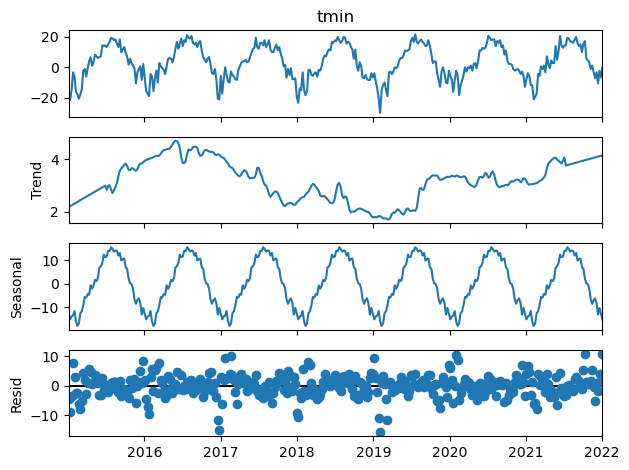

In [10]:
decomp.plot();

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
mod = SARIMAX(
    df["tmin"].resample("W").min(),
    order=(3, 0, 0),
    seasonal_order=(0, 1, 1, 52),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
)

In [13]:
r = mod.fit()

In [35]:
def sarima_forecast(data, config, start=None, end=None):
    order, sorder, trend = config
    model = SARIMAX(
        data,
        order=order,
        seasonal_order=sorder,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    model_fit = model.fit()

    if (start != None) & (end != None):
        prediction = model_fit.predict(start=start, end=end)
        print("Returning forecast")
        return prediction
    else:
        print("Returning fitted model")
        return model_fit

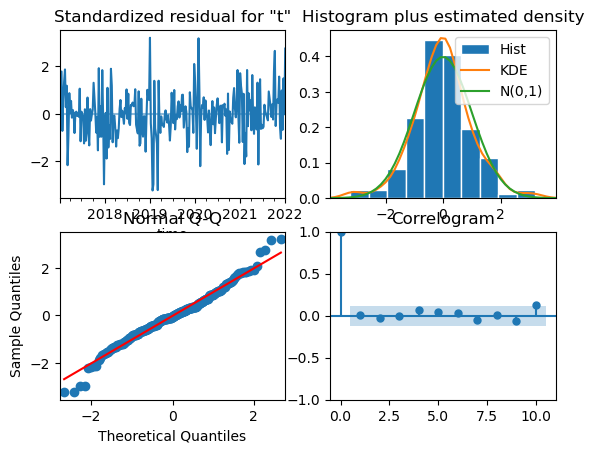

In [14]:
r.plot_diagnostics();

In [15]:
pred = r.get_prediction(start="2021-01-03", dynamic=False)

In [16]:
from sklearn.metrics import mean_squared_error

<Axes: xlabel='time'>

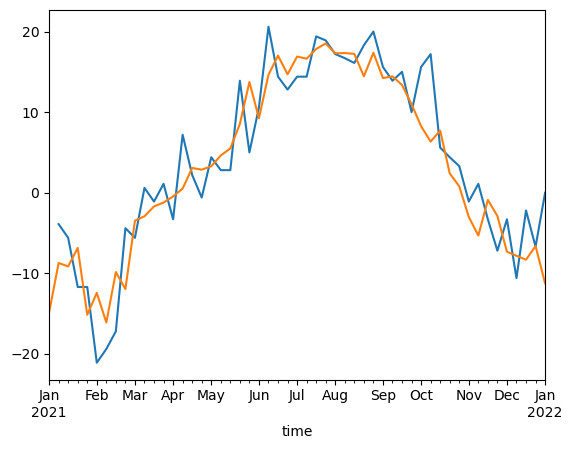

In [17]:
df["tmin"].resample("W").min().iloc[-52:].plot()
pred.predicted_mean.plot()

In [18]:
mean_squared_error(
    df["tmin"].resample("W").min()["2021-01-03":"2021-12-31"],
    pred.predicted_mean[0:52],
    squared=False,
)

4.232149294206734

In [19]:
type(pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

<Axes: >

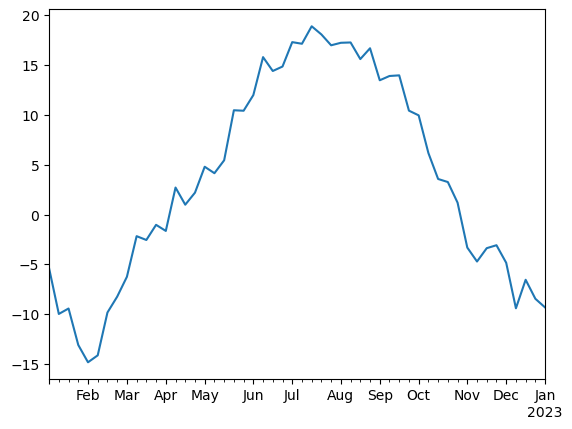

In [20]:
r.forecast("2022-12-31").plot()

<Axes: xlabel='time'>

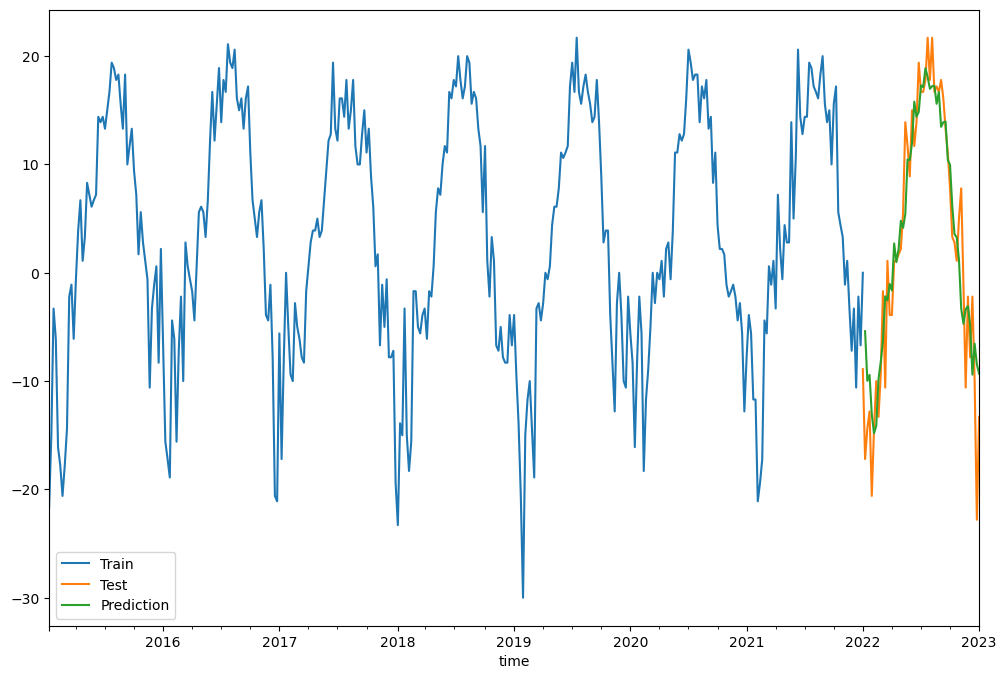

In [21]:
fig = plt.figure(figsize=(12, 8))
df["tmin"].resample("W").min().iloc[-365:].plot(label="Train", legend=True)
df_future["tmin"].resample("W").min().plot(label="Test", legend=True)
r.predict(start="2022-01-03", end="2022-12-31").plot(
    label="Prediction", legend=True
)

In [22]:
mean_squared_error(
    df_future["tmin"].resample("W").min()[1:53],
    r.predict(start="2022-01-03", end="2022-12-31"),
    squared=False,
)

4.5764297978456

In [23]:
df_future["tmin"].resample("W").mean()

time
2022-01-02    -5.000000
2022-01-09   -11.328571
2022-01-16    -6.971429
2022-01-23    -9.142857
2022-01-30   -13.114286
2022-02-06    -7.042857
2022-02-13    -5.314286
2022-02-20    -7.057143
2022-02-27    -4.757143
2022-03-06     1.185714
2022-03-13    -4.371429
2022-03-20     4.200000
2022-03-27     3.728571
2022-04-03     0.957143
2022-04-10     3.885714
2022-04-17     4.542857
2022-04-24     8.571429
2022-05-01     6.914286
2022-05-08     7.857143
2022-05-15    20.157143
2022-05-22    13.414286
2022-05-29    13.242857
2022-06-05    18.185714
2022-06-12    14.542857
2022-06-19    20.328571
2022-06-26    21.014286
2022-07-03    19.685714
2022-07-10    21.028571
2022-07-17    20.971429
2022-07-24    22.714286
2022-07-31    20.014286
2022-08-07    23.900000
2022-08-14    19.300000
2022-08-21    19.442857
2022-08-28    19.185714
2022-09-04    20.642857
2022-09-11    18.885714
2022-09-18    17.771429
2022-09-25    15.314286
2022-10-02    10.385714
2022-10-09     8.257143
2022-10-16 

In [39]:
predicted = sarima_forecast(
    df["tmin"].resample("W").min(), ((3, 0, 0), (0, 1, 1, 52), ("c"))
)

Returning fitted model


<Axes: >

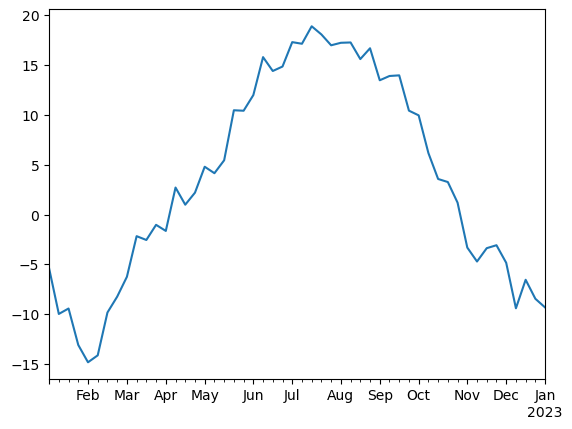